# Problem Set 5, due Wed, May 23rd, 5:30pm

### Attribute selection and PCA
This problem set focuses on attribute selection and principal component analysis (PCA) using linear regression as the main workhorse. We employ the Boston housing data from the good old days when median house was <50k... As always, the task is to predict the price (medv) using all the relevant features.

In [3]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import time

### 1 􏰀Active􏰁 data exploration
As the 􏰅rst step, add more features and explore the data.
1. Load the data. It is included in sklearn.datasets and you can 􏰅nd many copies on the internet too. Make sure you know the coding of all variables. In particular, you should be aware if a variable is categorical or numeric. Explain the coding scheme if it's not obvious.
2. Add some (10 or so) engineered features (synthetic features) to the data. As in the previous problem set, you may use various mathematical operations on a single or multiple features to create new ones.
3. Add another set (10 or so) bogus features, variables that have no relationship whatsoever to Boston housing market. You may just pick random numbers, or numbers from irrelevant sources, such as population of Chinese cities or baseball scores of yesteryear. Give these features distinct names (such as B1-B10) so you (and the reader) can easily recognize these later. You should have about 35 features in your data now.
4. Create a summary table where you show means, ranges, and number of missings for each variable. In addition, add correlation between the price and each variable. You may add more statistics you consider useful to this table.
5. Graphical exploration. Make a number of scatterplots where you explore the relationship between features and the value. Include a few features you consider relevant and a few you consider irrelevant here.


In [4]:
# load up the data
bos = load_boston()
features = bos.feature_names
bosdf = pd.DataFrame(bos.data, columns= features)

# engineered features
# i used q for the engineered features because it's more clear
bosdf['Q1'] = -np.log(bosdf['NOX'] ** bosdf['AGE'])
bosdf['Q2'] = np.log(bosdf['TAX'])
bosdf['Q3'] = np.log(bosdf['AGE'])
bosdf['Q4'] = bosdf['RAD'] ** bosdf['NOX']
bosdf['Q5'] = bosdf['CRIM'] ** bosdf['NOX']
bosdf['Q6'] = bosdf['NOX'] ** bosdf['CRIM']
bosdf['Q7'] = bosdf['NOX'] ** bosdf['RAD']
bosdf['Q8'] = np.log(bosdf['INDUS'])
bosdf['Q9'] = bosdf['INDUS'] ** bosdf['NOX']
bosdf['Q10'] = bosdf['LSTAT'] ** bosdf['NOX']

# bogus features - thee are x
bosdf['X1'] = np.random.randint(0, 256, bosdf.shape[0])
bosdf['X2'] = np.random.randint(0, 1024, bosdf.shape[0])
bosdf['X3'] = np.log(np.random.randint(1, 256, bosdf.shape[0]))
bosdf['X4'] = np.log(np.random.randint(1, 512, bosdf.shape[0]))
bosdf['X5'] = np.log(np.random.randint(2, 10, bosdf.shape[0]))
bosdf['X6'] = np.random.randint(2, 10, bosdf.shape[0])
bosdf['X7'] = np.random.randint(100, 250, bosdf.shape[0])
bosdf['X8'] = np.random.randint(6, 9, bosdf.shape[0])
bosdf['X9'] = np.log(np.random.randint(1, 25, bosdf.shape[0]))
bosdf['X10'] = np.log(np.random.randint(6, 9, bosdf.shape[0]))

# and this creates a dataframe that contains correlation info
feat = list(bosdf.columns)
pred = pd.DataFrame(bos.target, columns=["price"])
bosdf = bosdf.join(pred)

featuredf = pd.DataFrame(feat, columns=['index'])
cor = [ bosdf['price'].corr(bosdf[x]) for x in feat ]
boscorr = pd.DataFrame(cor, columns=['correlation'])
featuredf = featuredf.join(boscorr)


bosdescribe = bosdf.describe()[0:3].T
bosdescribe['null count'] = bosdf.isnull().sum()
bosdescribe = bosdescribe.reset_index()
boston = bosdescribe.join(featuredf, rsuffix='index')
boston

,index,count,mean,std,null count,indexindex,correlation
0,CRIM,506.0,3.593761,8.596783,0,CRIM,-0.385832
1,ZN,506.0,11.363636,23.322453,0,ZN,0.360445
2,INDUS,506.0,11.136779,6.860353,0,INDUS,-0.483725
3,CHAS,506.0,0.069170,0.253994,0,CHAS,0.175260
4,NOX,506.0,0.554695,0.115878,0,NOX,-0.427321
5,RM,506.0,6.284634,0.702617,0,RM,0.695360
6,AGE,506.0,68.574901,28.148861,0,AGE,-0.376955
7,DIS,506.0,3.795043,2.105710,0,DIS,0.249929
8,RAD,506.0,9.549407,8.707259,0,RAD,-0.381626
9,TAX,506.0,408.237154,168.537116,0,TAX,-0.468536


In [5]:
# let's look at these variables in particular that have
# a high correlation of some kind with price
high = featuredf[abs(featuredf['correlation']) >= .48]
high

,index,correlation
2,INDUS,-0.483725
5,RM,0.695360
10,PTRATIO,-0.507787
12,LSTAT,-0.737663
20,Q8,-0.519270
22,Q10,-0.618431


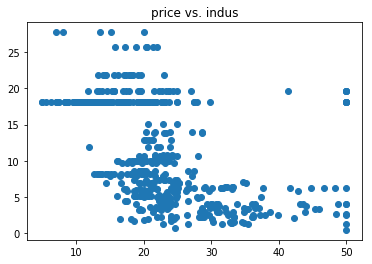

In [6]:
plt.scatter(bosdf.price, bosdf['INDUS'])
plt.title('price vs. indus')
plt.show()

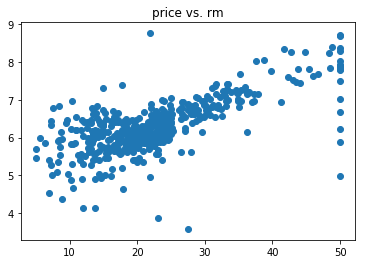

In [7]:
plt.scatter(bosdf.price, bosdf['RM'])
plt.title('price vs. rm')
plt.show()

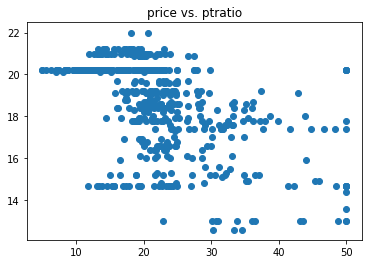

In [8]:
plt.scatter(bosdf.price, bosdf['PTRATIO'])
plt.title('price vs. ptratio')
plt.show()

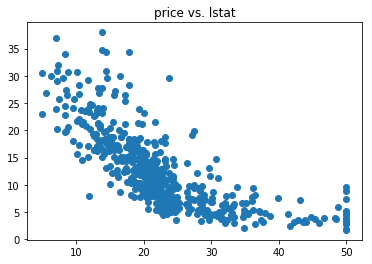

In [9]:
plt.scatter(bosdf.price, bosdf['LSTAT'])
plt.title('price vs. lstat')
plt.show()

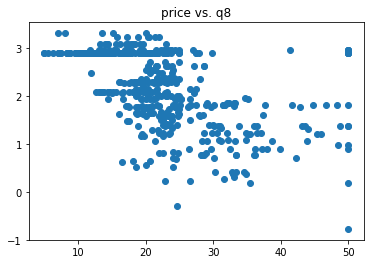

In [10]:
plt.scatter(bosdf.price, bosdf['Q8'])
plt.title('price vs. q8')
plt.show()

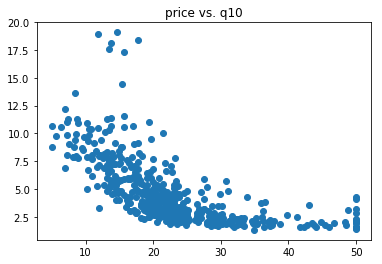

In [11]:
plt.scatter(bosdf.price, bosdf['Q10'])
plt.title('price vs. q10')
plt.show()

In [12]:
# let's look at these variables in particular that have
# a low correlation of some kind
low = featuredf[abs(featuredf['correlation']) <= .01]
low

,index,correlation
19,Q7,0.006190
25,X3,0.005771


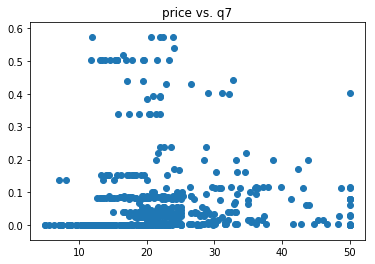

In [13]:
plt.scatter(bosdf.price, bosdf['Q7'])
plt.title('price vs. q7')
plt.show()

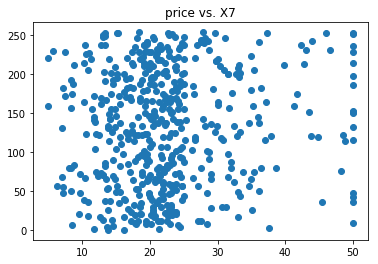

In [14]:
plt.scatter(bosdf.price, bosdf['X1'])
plt.title('price vs. X7')
plt.show()

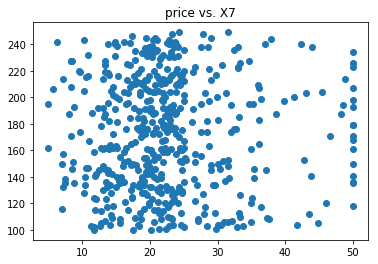

In [15]:
plt.scatter(bosdf.price, bosdf['X7'])
plt.title('price vs. X7')
plt.show()

### 2 Warm-up: a few simple models
Your 􏰅first real task, although just a warm-up, is to run a few linear models and evaluate their performance through cross-validation. You should code the loss function (mean squared errors) manually, and use this hand-made function throughout the rest of the problemset. You can use either a canned CV function from sklearn, or you can code your own.

#### 2.1 Loss function
Write a function that calculates the mean quadratic loss where N is the number of observations.

1/N (y − Xβ)′(y − Xβ)

1. Write this function. The function should take three inputs: a) the estimated model (or just the estimated parameters β); b) the test data X; and the test labels y. You may add other inputs if you consider it useful, for instance controls for print verbosity.

Ensure that the function is available through rest of the problem set. Also, please use this function for all following cross-validation exercises. If you are using canned cross-validation code, please ensure that the code uses your actual loss function!

In [123]:
# with much love and help to richard mcgovern for helping me
# through the matrix multiplication. this was a really tough/frusrating
# part of the assignment because i started off by doing it with loops
# instead of numpy
def mserror(X_data, y_data, model_params):
    N = len(y_data)
    residual = np.matrix(y_data) - (model_params @ X_data.as_matrix().T)
    # mean doesn't do anything here except convert the output to a float
    # from a matrix
    return np.mean(residual @ residual.T) / N

### 2.2 A Few Simple Regressions
Next, let's estimate and cross validate a few simple regressions.

1. Create a small model. It should include 1-2 variables you consider 􏰁relevant􏰂, i.e. features you think should be closely related to price.
2. 10-fold cross-validate this model to get the average MSE score (the value of your loss function).
3. Now build the next model with 10 features. Add more features you consider relevant but also those you consider irrelevant. Compute 10-fold MSE for this model.
4. Finally, include all your features and compute MSE. We call this the full model below.
5. Compare the results. Which has the best performance?

In [124]:
# i got a df with the items that have the highest correlation
two = featuredf[abs(featuredf['correlation']) >= .65]
twofeat = bosdf[two['index'].tolist()]

# we use this throughout the entire assignment, so just keep it here
kf = KFold(n_splits=10)

for train_index, test_index in kf.split(twofeat):
    twoX_train, twoX_test = twofeat.iloc[train_index], twofeat.iloc[test_index]
    twoy_train, twoy_test = bosdf.price.iloc[train_index], bosdf.price.iloc[test_index]
    
tworeg = LinearRegression()
twocoef = tworeg.fit(twoX_train, twoy_train).coef_

mserror(twoX_test, twoy_test, twocoef)

22.27431405072648

In [125]:
# some of the features in the dataframe here have less relevance
ten = featuredf[abs(featuredf['correlation']) >= .45]
tenfeat = bosdf[ten['index'].tolist()]

for train_index, test_index in kf.split(tenfeat):
    tenX_train, tenX_test = tenfeat.iloc[train_index], tenfeat.iloc[test_index]
    teny_train, teny_test = bosdf.price.iloc[train_index], bosdf.price.iloc[test_index]
    
tenreg = LinearRegression()
tencoef = tenreg.fit(tenX_train, teny_train).coef_

mserror(tenX_test, teny_test, tencoef)

17593.403952458495

In [126]:
# and this is everything 
full = bosdf.loc[:, bosdf.columns != 'price']

for train_index, test_index in kf.split(full):
    fullX_train, fullX_test = full.iloc[train_index], full.iloc[test_index]
    fully_train, fully_test = bosdf.price.iloc[train_index], bosdf.price.iloc[test_index]
    
fullreg = LinearRegression()
fullcoef = fullreg.fit(fullX_train, fully_train).coef_

mserror(fullX_test, fully_test, fullcoef)

17411.156180451966

The model with the lowest mean-squared error is the one with the fewest features. Consequently, it has the best performance. Intuitively this makes sense--the more features we add, the more error compounds. I am, however, surprised to see that error compounds that quickly. Finally, this doesn't describe how well the model actually fits the data--rather, it simply refers to the degree of error. We would have to take both model fit and error into account to weigh these outcomes effectively.

### 3 Find the best model

#### 3.1 Can we evaluate all models?

How much time would it take to evaluate all possible models? Let's 􏰅nd it out.

1. How many di􏰄erent linear regression models can you build based on the features you have (including the ones you generated)?
2. Run a test: run the following loop a number of times so that the total execution time is reasonably long (at least 5 seconds) but not too long.
(a) choose a random number of di􏰄erent features (b) estimate the model based on these features
(c) run 10-fold CV to get the MSE score for this model.
3. Based on the test timings, calculate how long time it would take to evaluate all the possible models. Would it be possible to store all the resulting MSE-s in your computer's memory?

In [109]:
# 1. If we have 33 features, and we assume that order doesn't matter but features can't be repeated, we have
# a combination equal to (n+r−1)! / r!(n−1)! . For the sake of curiosity,
# we're going to maximize the number of possible combinations and thus we cna
# take half of our n (16) and use that as our r value (this will make more sense taking into account later
# model outcomes where there is a good case to be made for a middling number of features).
# That gives us 48! / 16! (32!), which reduces to 2,254,848,913,647. This is a really big number.
#
# 2. Choose a number of features, estimate model, run 10fold CV and obtain MSE

modellist = []
errorlist = []

iterations = 450
start = time.time()

for i in range(iterations):
    models = np.random.choice(full.columns.tolist(),
                     np.random.choice(33, 1), replace=False)
    models = models.tolist()
    if len(models) > 0:
        errors = modelmaker(full[models], bosdf.price)
        modellist.append(models)
        errorlist.append(errors)
    
end = time.time()

timing = end-start

(2254848913647*timing)/iterations

#
# Using python's time.time() module, 450 iterations takes around 5.08 sec. To evaluate each model, it appears
# that it would take 806 years. 27880810151.251095 sec, specifically.
#
# My computer has 8gb of memory. If each of the possible combinations was 1 bit (which they are definitely not
# since a float is either 32 or 64b) then my computer could hold ~35 versions of every model in memory.
# Otherwise, no it definitely cannot. Thinking critically about this, PCA and models like forward selection
# allow us to get around this problem of too much dimensionality/too many combinations. If Python had dispensed
# with the GIL and allowed parallelism natively, then we might be able to address it better with a supercomputer.

29761684718.70518

#### 3.2 Forward selection
Next, let's implement the forward selection procedure to determine wich is the best model. Use 10-fold CV again to evaluate your models.
1. James et al. (2015, section 6.1), in particular page 207.
2. Create a series of 1-feature models and pick the best one by 10-fold CV.
Note: always include the constant.
3. Pick the feature with the lowest loss. This is your 1-feature model.
4. Repeat the procedure with more features until all features are included.
5. Pick the best model using Cp, AIC, BIC or adjusted R2 (consult James et al. (2015, section 6.1.3)). This is your forward-selection model.

In [144]:
# this function actually builds the model in the first place
# i wrapped everything up so it would be easier to use in a list comp
def modelmaker(features, ys, flag='no'):
    # divide the data
    for train_index, test_index in kf.split(features):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = ys.iloc[train_index], ys.iloc[test_index]
    # make the model
    lr = LinearRegression()
    coef = lr.fit(X_train, y_train).coef_
    mse = mserror(X_test, y_test, coef)
    score = lr.score(X_train, y_train)
    # and here's a switch between returning mse and the R^2 score
    if flag=='no':
        return mse
    if flag=='yes':
        return score
    
# this one chooses the one-feature model that has the lowest loss, iteratively producing
# a list that orders all of the other features in terms of their loss
def losspicker(features):
    modellist = []
    featureset = features.columns.tolist()
    for i in features.columns:
        value = [ modelmaker(features[[j]], bosdf.price) for j in featureset ]
        test = value.index(min(value))
        modellist.append(featureset[test])
        featureset.remove(featureset[test])
    return modellist

# generate a list of lists, each list composed of the items before it, for model evaluation
# i realized too late i could just use an asterisk to unpack the arguments, so i keep this method
def listmaker(listy):
    backup = []
    for i in range(len(listy)):
        var = listy[:i+1]
        backup.append(var)
    return backup

# in this case 'B' starts our first model
listy = listmaker(losspicker(full))

# use listmaker to generate a list of all of the different possible features and then
# run through them and calculate R2, maximizing R2.

mserrorrate = [ modelmaker(full[listy[i]], bosdf.price) for i in range(len(listy)) ]
print(mserrorrate)
# after running the loop, we see that the best model (using mserror)
# is the one that contains all features. it is curious, however, that there are a number
# of utterly inconsequential features at [15], consisting of:
#
# ['B','Q6','DIS','X4','X8','X7','Q7','ZN','CHAS','X9','X1','X3','X6','X2','Q1','X5']
#
# i suppose technically the best model could be the one that gives the most performance
# with the fewest extraneous features. As such, the model that lives at [28] looks pretty good.
#
# ['B','Q6','DIS','X1','X8','X10','X5','X4','Q7','ZN','CHAS','X6','X7','X3','X9'
# 'X2','Q1','CRIM','Q5','Q4','RAD','Q9','AGE','Q10','INDUS','LSTAT','TAX','Q8','RM']
#
# at [28] we get ~75% variance explained with the most compact model.
#
# remember, however, that we are not taking into account MSE (except implicitly in the calculation
# of r^2). we should probably look at the adjusted r^2 in concert with r^2 to gauge which number of features is best
#
adjrsquared = [ (1 - modelmaker(full[listy[i]], bosdf.price, flag='yes')) for i in range(len(listy)) ]
print(adjrsquared)
# based on this it looks like [28] is the best.

[57.58448648605329, 46.499243530046876, 113.93970764328594, 123.19220354343658, 109.0256864639249, 116.63060088813971, 98.3947218237749, 100.98842599225256, 95.8654550610184, 94.72212921162959, 110.38620468755482, 169.77615409115143, 206.00908230023668, 215.39110914879086, 216.2871508260691, 230.88737861994187, 314.9840376110517, 872.7089900274375, 1331.65640275391, 1687.6686011603908, 1273.4773859606616, 2037.8805126396715, 1969.6090515325504, 1633.1458273714866, 2122.5156112673844, 1726.4483818275933, 2511.203370335084, 3494.703519541827, 626.7875323728483, 956.9279079917594, 1332.9140463825495, 2747.221089615613, 17411.156180450205]
[0.8841570616119325, 0.8840171864228743, 0.7967921625100463, 0.7949769293974582, 0.7921705581412682, 0.7920912821778411, 0.7908605408921926, 0.790833519220973, 0.7907756181883085, 0.7907719910178039, 0.7750527282120583, 0.6917112595608, 0.6689993228517627, 0.6687531972874794, 0.6687503944123897, 0.6684476380437004, 0.647171805327289, 0.5829188314715577, 

### 4 Principal components
Can we compress the feature space with PCA and use substantially fewer features? Let's try.


#### 4.1 Use raw features
Although in case of PCA the featurs should be normalized, let's start with the raw features with no normalization.
I expect you to use canned packages, such as PCA in sklearn, but you are welcome to experiment with eigenvalue decomposition yourself (consult Leskovec et al. (2014, chapter 11), available on canvas).
Note: certain PCA packages may perform normalization by default. Please ensure that you switch o􏰄 this option.
1. Consult James et al. (2015) sections 6.3 and 10.2.
2. Perform Principal Component Analysis on all the features in your data (except the target (price)
medv).
Extract all components (the number should equal to the number of features) and report:
(a) Variance explained by each component
(b) Proportional variance explained by each component
(c) Cumulative variance explained up to each component.
3. Rotate data: rotate the original features according to the principal components. Most packages have this function built-in but you can consult Leskovec et al. (2014, chapter 11.2.1) for details and interpretation.
4. Find the optimal model in rotated data: estimate the regression model explaining the housing value by the rotated features. Start with the 􏰅rst (most important) rotated feature and add rotated features to the model one-by-one. Each time cross-validate your result.
5. Show a plot how cross-validated MSE depends on the number of components. Which number of components will give you the smallest MSE?

In [103]:
pca = PCA(n_components=33)
pcafull = pca.fit(full)
exvar = pcafull.explained_variance_
propxvar = pcafull.explained_variance_ratio_
cumsumvar= np.cumsum(np.round(propxvar, decimals=6)*100)
vardf = pd.DataFrame(exvar, propxvar).reset_index()
vardf.columns = ['proportional variance', 'variance by component']
vardf

,proportional variance,variance by component
0,6.587138e-01,88384.136237
1,2.299246e-01,30850.562216
2,4.665992e-02,6260.680909
3,4.087830e-02,5484.921526
4,1.328584e-02,1782.651928
5,6.805195e-03,913.099517
6,2.196011e-03,294.653761
7,6.456522e-04,86.631564
8,3.951810e-04,53.024134
9,2.026413e-04,27.189774


In [105]:
# and this dataframe details the cumulative summing of above
# cumulative sum of variance explained with [n] features
var=np.cumsum(np.round(variance, decimals=6)*100)
cumsum = pd.DataFrame(var)
cumsum.columns = ['cumulative summing of explained variance ratio']
cumsum
# somehow i am not surprised that the engineered features don't influence the outcome too much :)

,cumulative summing of explained variance ratio
0,65.8714
1,88.8639
2,93.5299
3,97.6177
4,98.9463
5,99.6268
6,99.8464
7,99.9110
8,99.9505
9,99.9708


In [201]:
def pcamaker(features, ys, flag='no'):
    # divide the data
    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(features):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = ys.iloc[train_index], ys.iloc[test_index]
    # make the model
    pca = PCA(n_components=int(features.shape[1]))
    pcf = pca.fit_transform(X_train, y_train)
    mse = mserror(X_test, y_test, pcf)
    score = pca.score(X_train, y_train)
    # and here's a switch between returning mse and the R^2 score
    if flag=='no':
        return mse
    if flag=='yes':
        return score
    
def pcalosspicker(features):
    modellist = []
    featureset = features.columns.tolist()
    for i in features.columns:
        value = [ pcamaker(features[[j]], bosdf.price) for j in featureset ]
        test = value.index(min(value))
        modellist.append(featureset[test])
        featureset.remove(featureset[test])
    return modellist

list2 = listmaker(pcalosspicker(full))

# and this produces the function that displays the overall loss
msepca = [ pcamaker(full[i], bosdf.price, flag='no') for i in list2 ]

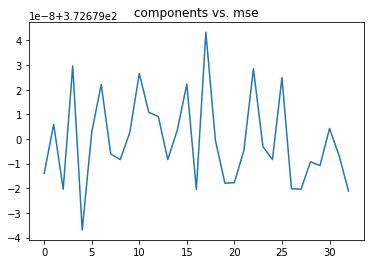

In [202]:
# here you can disregard 0, because i didn't include the intercept
#
# i am pretty sure I addressed this question correctly, but it looks like
# there is a really bizarre peak point at 31-32 where mse maxes out. not good.
# i would guess that the lowest error hovers around 4 components, or perhaps 16,
# based on the scale.
plt.plot(msepca)
plt.title('components vs. mse')
plt.show()

### 4.2 PCA on normalized data
Now let's normalize the data. I expect you to do it manyally, i.e. to write a function that for a given feature vector x computes:

x^n = (x − x􏰀bar) / sdx
where x􏰀 is the mean of the x and sd x is it's standard deviation.

1. Code such a function and apply this to all explanatory variables in your data (but not to the target). This gives you a normalized data matrix Xn.
2. Repeat the analysis in 4.1 with normalized data.

In [182]:
def normalizer(i):
    return (i - np.mean(i)) / np.std(i)

# let's transpose the entire dataframe so we can then 
# fit the data and then transpose it back
normalized = [ normalizer(full[i]) for i in full.columns ]
bosnormalized = pd.DataFrame(normalized).T
pcanorm = pca.fit(bosnormalized)
normxvar = pd.DataFrame(pcanorm.explained_variance_, columns=['explained variance'])
normxvar

,explained variance
0,11.491880
1,2.695106
2,1.954745
3,1.457858
4,1.335900
5,1.211546
6,1.102117
7,1.078551
8,1.052138
9,1.013795


In [183]:
# and this dataframe details ex. var ratio
normvariance = pcanorm.explained_variance_ratio_
normvardf = pd.DataFrame(normvariance)
normvardf.columns = ['normed explained variance ratio']
normvardf

,normed explained variance ratio
0,0.347551
1,0.081508
2,0.059118
3,0.044090
4,0.040402
5,0.036641
6,0.033331
7,0.032619
8,0.031820
9,0.030660


In [184]:
normvarcumsum=np.cumsum(np.round(normvariance, decimals=6)*100)
normvarcumsumdf = pd.DataFrame(normvarcumsum)
normvarcumsumdf.columns = ['normed cumulative sum']
normvarcumsumdf
#
# this is a much more effective summarization of the data;
# it is even more clear that the components that we engineered
# do not provide us with much insight over the data.
# our made up data only gives us like 1%

,normed cumulative sum
0,34.7551
1,42.9059
2,48.8177
3,53.2267
4,57.2669
5,60.9310
6,64.2641
7,67.5260
8,70.7080
9,73.7740


In [214]:
list3 = listmaker(pcalosspicker(bosnormalized))
list3

# i scaled my output here rather than in the plot, just because it was easier
msepca2 = [ pcamaker(bosnormalized[i], bosdf.price)-372 for i in list3 ]

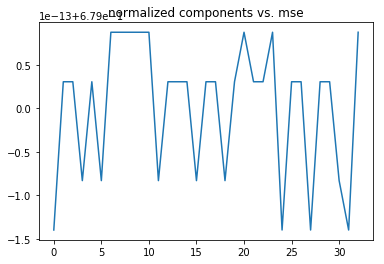

In [215]:
plt.plot(msepca2)
plt.title('normalized components vs. mse')
plt.show()
# the plot suggests that (again, disregarding the 0 point), that error
# is minimized locally at 4 and 5 features, and globally at 24, 26, and 31 features

### 4.3 What's the best solution?

Compare all your results: full model, forward selection, PCA on raw data, and PCA on normalized data. Which one is most precise? Which one is most compact? Which one is the easiest to do? Which one
is the most straightforward to interpret?

For the sake of argument, I think that PCA is the most precise, provided we effectively normalize the data to ensure that it's representing what we want it to represent (i.e. not just showing the variance in the data; that scaling issue that we talked about in class). PCA on raw data gets us most of the way there, but not quite.

I would argue that forward selection has the potential to be the most or the least compact, mostly because of the human evaluative criteria involved. As I specified above, I ended up selecting the largest R^2 value with the fewest features used. Depending on the area under the curve you want to cover, you may select a more or less compact model. There's the most interpretability here, which means that it has the greatest possiblity for compactness or verbosity.

The easist method to use, and the most straightforward to do, is the full model evaluation. The technique to build the full model evaluation required the least amount of thought for me to conceptualize and execute. However, in contrast to the others, it also produces the most error (comparatively speaking), which is something to be wary of.

PCA on normalized data is the most straightforward to interpret (from my perspective) because the degree of dimensionality reduction that it provides easily maps onto human understanding. Combining that with the cumulative summing process makes it really easy to practically interpret, as well. Since the data is scaled, the length of one of the vectors given by the PC decomposition gives us a 'relevance' or 'importance' factor, as well as the overall tendency. It does require some clear understanding of complex mathematical models (i.e. eigenvalue decomposition) to ensure that you know what you are doing when putting together the model or doing transformations, but you don't necessarily have to *know* that to be able to interpret it. It requires the most work to get to that point, but it's the easiest to interpret.

I had a lot of trouble with problem 4 of this assignment (particularly the linear regression pca model fitting material) so please be gentle. Basically, after forward selection (which was tough in its own way), things got really complicated really fast. -K